# Transformación de datos

<img src="imagenes/proceso.png" style="width:60em; margin: 0 auto;"/>

Una vez tenemos un conjunto de datos que:
1. sabemos que contiene la información que buscamos
2. está limpio de valores "problemáticos"

nos queda aún un paso para poder procesarlo. Este paso es necesario porque los datos vienen dados en el formato más apropiado para la fuente que los genera, mientras que los algoritmos de procesado tienen sus propios formatos que no siempre coinciden con los primeros. 

---

# Índice
[Reindexado](#Reindexado) <br/>
[Combinar datos de distintos DataFrame](#Combinar-datos-de-distintos-DataFrame) <br/>
&nbsp;&nbsp;&nbsp;&nbsp; [Combinación de columnas](#Combinación-de-columnas) <br/>
&nbsp;&nbsp;&nbsp;&nbsp; [Concatenación](#Concatenación) <br/>
[Dividir/aplicar/combinar](#Dividir/aplicar/combinar) <br/>
[Feature engineering](#Feature-engineering) <br/>
&nbsp;&nbsp;&nbsp;&nbsp; [Combinación de columnas con una fórmula conocida](#Combinación-de-columnas-con-una-fórmula-conocida) <br/>
&nbsp;&nbsp;&nbsp;&nbsp; [Clasificación por reglas conocidas](#Clasificación-por-reglas-conocidas) <br/>
[Conclusiones](#Conclusiones) <br/>


---

Por ejemplo, podemos tener datos que se generan como tablas de series temporales con una frecuencia de 15 minutos, como vimos en el ejemplo de un sistema de monitorización de aparcamientos:

<img src="imagenes/parkingT.png" style="width:30em; margin: 0 auto;"/>
<br/>

En esta tabla, hemos marcado los intervalos en los que todas las plazas están ocupadas, es decir, en los intervalos de atasco. Supongamos que queremos buscar patrones de repetición de horas y duraciones en los atascos, y tenemos para ello un algoritmo de procesado de datos. No obstante, este algoritmo requiere un vector por cada atasco, que indique el inicio y duración de cada atasco. La tabla anterior debería transformarse en lo siguiente:

<img src="imagenes/parkingD.png" style="width:20em; margin: 0 auto;"/>
<br/>

Las transformaciones son operaciones menos estandarizadas, dado que hay muchos formatos de entrada y salida posibles. Muchas veces, para lograr la transformación adecuada, tendremos que ajustar las operaciones de forma iterativa, es decir, observar los datos originales, realizar una serie de transformaciones, ver el resultado, repetir ... hasta lograr el resultado deseado. Es aquí donde herramientas como Python y Jupyter muestran su verdadera potencia. Pandas es especialmente importante en esta fase, dado que ofrece muchas funciones comunes en la transformación de datos. 

Como se muestra en el gráfico del procesado de datos, la transformación de datos también tiene como objetivo reducir la dimensionalidad y la información superflua. La dimensionalidad implica normalmente un número de columnas o filas demasiado alto, que puede introducir "ruido" en el algoritmo de procesado de datos. Un número de columnas demasiado alto pueden hacer que un algoritmo de procesado no converja, o interprete la importancia de una columna de forma errónea, dando lugar a la detección de patrones incorrectos. En esos casos hay que eliminar las columnas superfluas o bien combinar varias en una única (también llamado <i>feature engineering</i>). Respecto a las filas, como hemos visto en el ejemplo del parking, puede que no necesitemos todos los detalles que ofrecen las fuentes de datos (en ese caso, el funcionamiento del parking fuera de las horas de atasco).

En esta libreta veremos algunas operaciones que se dan con frecuencia en la transformación de datos, que serán los elementos que en el futuro nos permitirán acometer problemas de muchos tipos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Reindexado

A menudo, una de las operaciones que tendremos que realizar es cambiar el índice de un <code>DataFrame</code>. Ya vimos esta operación cuando teníamos que rellenar filas completas omitidas en series temporales. Para ello usábamos el método <code>.reindex</code>. Esta operación se puede aplicar en cualquier tipo de <code>DataFrame</code> y de índice que pueda generarse en forma de lista. Esto puede dar lugar a datos omitidos. 

Otra función que nos permite modificar el índice es <code>.set_index</code> que nos permite usar los valores de una columna como índice. Supongamos que tenemos una lista de usuarios indexados por su identificador:

In [2]:
usuarios = pd.read_csv("datos/usuarios.csv", index_col=0)
usuarios

,username,email,type,points
ID,,,,
1000,alice,alice@acme.com,administrator,23
1001,bob,bob@buynlarge.com,invited,12
1002,charles,charles@cyberdyne.net,invited,5
1004,greg,greg@globex.us,invited,8
1006,mary,mary@momcorp.com,administrator,19


Podemos usar la columna <code>username</code> como índice:

In [3]:
usuarios.set_index("username")

,email,type,points
username,,,
alice,alice@acme.com,administrator,23
bob,bob@buynlarge.com,invited,12
charles,charles@cyberdyne.net,invited,5
greg,greg@globex.us,invited,8
mary,mary@momcorp.com,administrator,19


Dos observaciones acerca de esta operación. La primera es que la columna seleccionada debe tener valores únicos. La segunda es que los valores del índice desaparecen, por lo que si tienen información importante, antes deberíamos crear una columna nueva con esa información:

In [4]:
usuarios_reindexado = usuarios.copy()
usuarios_reindexado["ID"] = usuarios_reindexado.index
usuarios_reindexado = usuarios_reindexado.set_index("username")
usuarios_reindexado

,email,type,points,ID
username,,,,
alice,alice@acme.com,administrator,23,1000
bob,bob@buynlarge.com,invited,12,1001
charles,charles@cyberdyne.net,invited,5,1002
greg,greg@globex.us,invited,8,1004
mary,mary@momcorp.com,administrator,19,1006


<div style="background-color:lightpink; padding:1em"><b>Ejercicio 1</b><br/>
    <p>Genere un nuevo <code>DataFrame</code> con los contenidos de <code>usuarios</code> indexados por el correo electrónico. Recuerde guardar antes el índice anterior.</p>
</div>

## Combinar datos de distintos <code>DataFrame</code>

Es muy común que los datos que usemos provengan de diveras fuentes de datos. La combinación de datos que pueden provenir de fuentes con una naturaleza muy diversa y cuyas relaciones pueden no ser evidentes a simple vista, puede ser un objetivo en sí misma. Pero antes de ir a estos casos más complejos, necesitamos ver las herramientas que tenemos para combinar datos simples. Antes de poder buscar relaciones entre datos de distintos orígenes, necesitamos "alinearlos", es decir, emparejar las muestras de acuerdo a una regla concreta. El ejemplo más evidente es alinearlas en el tiempo, agrupando muestras tomadas en un mismo intervalo temporal en la misma fila. También podríamos agruparlos por unidades geográficas, identificadores personales, etc.

En este punto, veremos dos tipos de combinación de datos. El primero, el más complejo, consistirá en tomar <code>DataFrame</code> de distintos ficheros y combinar sus columnas. No podemos concatenar simplemente los datos; dado que tienen que hacerlo con un orden determinado, de acuerdo al índice o al valor de una columna. El segundo tipo de combinación será la simple concatenación de filas. Esta operación es muy común en datos que se recogen por bloques.

### Combinación de columnas

En este tipo de combinación, tomaremos datos de dos ficheros que tienen una columna común. Empezaremos por el caso más simple, en el que queremos alinear los datos de acuerdo al índice. A continuación, veremos cómo podemos alinearlos según los valores de una columna. Para ambos casos, veremos el caso en el que coincidan los datos en ambas tablas y en los que haya maś entradas en una de ellas.

#### Alineación con índice

Supongamos que tenemos un fichero con más información acerca de los usuarios del <code>DataFrame</code> anterior:

In [5]:
usuarios_extra = pd.read_csv("datos/usuarios_extra.csv", index_col=0)
usuarios_extra

,full name,group,home
ID,,,
1006,Mary Murphy,remote,/home/mar
1002,Charles Chaplin,remote,/home/cha
1001,Bob Barnett,wheel,/home/bob
1000,Alice Anderson,wheel,/home/ali
1004,Greg Gantt,remote,/home/gre


Recordemos la tabla original:

In [6]:
usuarios

,username,email,type,points
ID,,,,
1000,alice,alice@acme.com,administrator,23
1001,bob,bob@buynlarge.com,invited,12
1002,charles,charles@cyberdyne.net,invited,5
1004,greg,greg@globex.us,invited,8
1006,mary,mary@momcorp.com,administrator,19


Un aspecto importante es que las filas están dadas en un orden diferente. Pandas es capaz de inferir que al hacer una simple asignación de columnas, colocará cada entrada en su fila correspondiente:

In [7]:
usuarios_ampliado = usuarios.copy()
usuarios_ampliado.loc[:,"full name"] = usuarios_extra.loc[:,"full name"]

In [8]:
usuarios_ampliado

,username,email,type,points,full name
ID,,,,,
1000,alice,alice@acme.com,administrator,23,Alice Anderson
1001,bob,bob@buynlarge.com,invited,12,Bob Barnett
1002,charles,charles@cyberdyne.net,invited,5,Charles Chaplin
1004,greg,greg@globex.us,invited,8,Greg Gantt
1006,mary,mary@momcorp.com,administrator,19,Mary Murphy


Como vemos, creamos una nueva tabla <code>usuarios_ampliado</code> como una copia de <code>usuarios</code>, y a continuación le asignamos una columna nueva <code>full name</code> con los datos de <code>usuarios_extra</code>. Con esto asignamos una única columna. ¿Y cómo asignamos todas? Mediante la función <code>concat</code> de la librería Pandas:

In [9]:
pd.concat([usuarios, usuarios_extra], axis=1)

,username,email,type,points,full name,group,home
ID,,,,,,,
1000,alice,alice@acme.com,administrator,23,Alice Anderson,wheel,/home/ali
1001,bob,bob@buynlarge.com,invited,12,Bob Barnett,wheel,/home/bob
1002,charles,charles@cyberdyne.net,invited,5,Charles Chaplin,remote,/home/cha
1004,greg,greg@globex.us,invited,8,Greg Gantt,remote,/home/gre
1006,mary,mary@momcorp.com,administrator,19,Mary Murphy,remote,/home/mar


Varias puntualizaciones sobre esta línea de código. En primer lugar, la función <code>concat</code> es parte de la libraría Pandas, por lo que la invocamos como <code>pd.concat</code> y no como un método de alguno de los <code>DataFrame</code>. En segundo lugar, el parámetro que le pasamos a <code>concat</code> es una lista con los <code>DataFrame</code> que queremos combinar. Y finalmente, tenemos que pasar el parámetro <code>axis=1</code>, que significa que queremos concatenar por columnas y no por filas (<code>axis=0</code> o no dando un valor al parámetro; veremos este caso en unos instantes). Pandas sabe cómo recolocar las filas de modo que todos los valores de todas las columnas estén en el índice apropiado. La salida de <code>concat</code> es un nuevo <code>DataFrame</code>, que podremos asignar a una nueva variable.

<div style="background-color:lightpink; padding:1em"><b>Ejercicio 2</b><br/>
    <p>Lea los ficheros <code>pacientes.csv</code> y <code>pacientes_extra.csv</code> y concatene las columnas.</p>
</div>

Puede pasar que uno de los ficheros tenga índices que no estén presentes en el otro. En esos casos, Pandas crea la entrada para esas filas, dejando valores nulos en las columnas que faltan en ellas:

In [10]:
usuarios_extra2 = pd.read_csv("datos/usuarios_extra2.csv", index_col=0)
usuarios_extra2

,full name,group,home
ID,,,
1006,Mary Murphy,remote,/home/mar
1002,Charles Chaplin,remote,/home/cha
1001,Bob Barnett,wheel,/home/bob
1000,Alice Anderson,wheel,/home/ali
1004,Greg Gantt,remote,/home/gre
1003,Daniel Dean,wheel,/home/dan


In [11]:
pd.concat([usuarios, usuarios_extra2], axis=1)

,username,email,type,points,full name,group,home
ID,,,,,,,
1000,alice,alice@acme.com,administrator,23.0,Alice Anderson,wheel,/home/ali
1001,bob,bob@buynlarge.com,invited,12.0,Bob Barnett,wheel,/home/bob
1002,charles,charles@cyberdyne.net,invited,5.0,Charles Chaplin,remote,/home/cha
1003,NaN,NaN,NaN,NaN,Daniel Dean,wheel,/home/dan
1004,greg,greg@globex.us,invited,8.0,Greg Gantt,remote,/home/gre
1006,mary,mary@momcorp.com,administrator,19.0,Mary Murphy,remote,/home/mar


#### Alineación por valores de una columna con valores únicos iguales

No siempre tendremos tablas que compartan índice. Puede darse el caso de que querramos alinear los datos según una columna. Veamos primero el caso simple en el que todos los valores de la columna de un <code>DataFrame</code> están en la columna correspondiente del otro. En nuestro caso, vamos a leer una tabla con datos estadísticos de los usuarios:

In [12]:
usuarios_estadisticas = pd.read_csv("datos/usuarios_estadisticas.csv", index_col=0)
usuarios_estadisticas

,username,login attempts,login success
0,alice,232,229
1,mary,89,86
2,bob,201,180
3,greg,14,14
4,charles,131,121


Como podemos ver, todos los nombres de usuario presentes en esta tabla, también están en la tabla <code>usuarios</code>. ¿Cómo podemos crear un nuevo <code>DataFrame</code> que contenga los datos de <code>usuarios</code> y que además tenga las columnas de <code>usuarios_estadisticas</code> correctamente asignados? Para ello, tenemos que introducir un nuevo tipo de operación, muy común en bases de datos, llamada <i>join</i>, es decir, unión. Esta operación consiste en la alineación que hicimos en el apartado anterior pero usando una columna del <code>DataFrame</code>. No obstante, se añaden algunas abstracciones, como qué hacer cuando en una de las tablas hay valores que no están presentes en el otro, cuál de las dos tablas es la que se toma como referencia o qué hacer con los valores duplicados. Antes de ver todas estas particularidades, veamos cómo funciona para el caso más sencillo en Pandas, en el que tenemos la tabla <code>usuarios</code> y la tabla <code>usuarios_estadísticas</code> en las cuales la columna <code>username</code> nos permite alinear los datos. Todos los usuarios están representados en ambas tablas.

In [13]:
usuarios.join(usuarios_estadisticas.set_index("username"), on="username")

,username,email,type,points,login attempts,login success
ID,,,,,,
1000,alice,alice@acme.com,administrator,23,232,229
1001,bob,bob@buynlarge.com,invited,12,201,180
1002,charles,charles@cyberdyne.net,invited,5,131,121
1004,greg,greg@globex.us,invited,8,14,14
1006,mary,mary@momcorp.com,administrator,19,89,86


Analicemos el código. En primer lugar, hemos tomado la tabla <code>usuarios</code> como nuestra referencia, o tabla <i>izquierda</i>. Hemos llamado al método <code>join</code> de la misma, y hemos pasado como parámetro principal la tabla <code>usuarios_estadísticas</code>, que también llamaremos tabla <i>derecha</i>. Dicha tabla tiene que tener la columna de referencia como índice, en este caso <code>username</code>, por lo que hemos asignado dicha columa como índice (NOTA: <code>usuarios_estadisticas.set_index("username")</code> se ejecuta antes de la llamada a <code>join</code> de modo que lo que se pasa a esta última llamada es el resultado de la primera). Finalmente, en el parámetro <code>on="username"</code> especificamos la columna de la tabla izquierda que se tendrá que alinear con el índice de la derecha.

Siempre llamaremos el método join sobre la tabla izquierda, y pasaremos la derecha como parámetro. En otras palabras, la operación join va de izquierda a derecha, en el sentido de la lectura. Esto tendrá mucho más sentido cuando empiecen a aparecer complejidades como las que vamos a ver a continuación.

#### Alineación por valores de una columna con valores únicos distintos

Supongamos ahora que tenemos una tabla de estadísticos de usuarios en los que hay usuarios de la tabla <code>usuarios</code> que faltan y otros que no están presentes en la primera:

In [14]:
usuarios_estadisticas2 = pd.read_csv("datos/usuarios_estadisticas2.csv", index_col=0)
usuarios_estadisticas2

,username,login attempts,login success
0,mary,89,86
1,charles,131,121
2,helen,32,30
3,greg,14,14
4,alice,232,229
5,john,66,59


Podemos ver que se da la siguiente situación:
- Los usuarios <code>alice</code>,<code>charles</code>,<code>greg</code> y <code>mary</code> están tanto en <code>usuarios</code> como en <code>usuarios_estadisticas2</code>.
- El usuario <code>bob</code> sólo está en <code>usuarios</code>.
- Los usuarios <code>helen</code> y <code>john</code> sólo están en <code>usuarios_estadisticas2</code>.

En Teoría de Conjuntos, podemos representar esta situación de la siguiente manera:

<img src="imagenes/intersection.png" style="width:20em; margin: 0 auto;"/>
<br/>

En este caso, podríamos hacer varios tipos de operación join. Por un lado, tendríamos la opción de usar la tabla izquierda como referencia. En este caso (que es el comportamiento por defecto), Pandas crea un nuevo dataframe que tiene todos los nombres de usuario presentes en la tabla izquierda y rellena con datos de la derecha donde éstos existan. Gráficamente, el diagrama de Venn que representa esto es el siguiente:

<img src="imagenes/intersection_left.png" style="width:20em; margin: 0 auto;"/>
<br/>

In [15]:
usuarios.join(usuarios_estadisticas2.set_index("username"), on="username")

,username,email,type,points,login attempts,login success
ID,,,,,,
1000,alice,alice@acme.com,administrator,23,232.0,229.0
1001,bob,bob@buynlarge.com,invited,12,NaN,NaN
1002,charles,charles@cyberdyne.net,invited,5,131.0,121.0
1004,greg,greg@globex.us,invited,8,14.0,14.0
1006,mary,mary@momcorp.com,administrator,19,89.0,86.0


Si cambiamos de sitio las tablas, tendremos el conjunto opuesto (es decir, el formado por <code>alice</code>,<code>charles</code>,<code>greg</code>, <code>mary</code>, <code>helen</code> y <code>john</code>.

Por otro lado, tenemos la posibilidad de tomar sólo las filas con entradas en ambas tablas, de modo que no haya datos omitidos. Para ello, tenemos que usar el parámetro <code>how="inner"</code> de <code>join</code>. Veamos primero el diagrama de Venn (que explica el valor <code>"inner"</code> para el parámetro <code>how</code>) y luego el código:


<img src="imagenes/intersection_inner.png" style="width:20em; margin: 0 auto;"/>
<br/>

In [16]:
usuarios.join(usuarios_estadisticas2.set_index("username"), on="username", how="inner")

,username,email,type,points,login attempts,login success
ID,,,,,,
1000,alice,alice@acme.com,administrator,23,232,229
1002,charles,charles@cyberdyne.net,invited,5,131,121
1004,greg,greg@globex.us,invited,8,14,14
1006,mary,mary@momcorp.com,administrator,19,89,86


Finalmente, si queremos tener todas las entradas presentes en ambas tablas, usamos <code>how="outer"</code>:

<img src="imagenes/intersection_outer.png" style="width:20em; margin: 0 auto;"/>
<br/>

In [17]:
usuarios.join(usuarios_estadisticas2.set_index("username"), on="username", how="outer")

,username,email,type,points,login attempts,login success
1000.0,alice,alice@acme.com,administrator,23.0,232.0,229.0
1001.0,bob,bob@buynlarge.com,invited,12.0,NaN,NaN
1002.0,charles,charles@cyberdyne.net,invited,5.0,131.0,121.0
1004.0,greg,greg@globex.us,invited,8.0,14.0,14.0
1006.0,mary,mary@momcorp.com,administrator,19.0,89.0,86.0
NaN,helen,NaN,NaN,NaN,32.0,30.0
NaN,john,NaN,NaN,NaN,66.0,59.0


<div style="background-color:lightpink; padding:1em"><b>Ejercicio 3</b><br/>
    <p>Lea e inspeccione el fichero <code>pacientes_extra2.csv</code>. Esta tabla representa los datos de los pacientes adscritos a un programa de monitorización del peso. No todos los usuarios de la tabla resultante en el Ejercicio 2 están presentes en esta tabla, y no todos los que están en esta tabla están en la anterior. Nos interesa obtener una tabla que describa todos los datos de los usuarios presentes en la tabla del Ejercicio 2 y que forman parte del programa de monitorización del peso. Concatene los datos del fichero leído con los del Ejercicio 2. Tenga en cuenta que no nos interesan los datos de las personas que no están representadas en ambas tablas, por lo que deberá elegir el tipo de join más apropiado. Tenga también en cuenta que hay que usar la columna <code>Historial</code> para hacer el <code>join</code>.</p>
</div>

#### Alineación por valores de una columna con valores repetidos

Hay un caso más de join, que es aquel en el que en una de las columnas tiene valores repetidos. Esto se puede dar cuando tenemos una tabla en la que se hace referencia (con posibilidad de repetición) a entidades individuales descritas en otra tabla. Veremos el caso en el que sólo la tabla izquierda tiene valores repetidos.

Por ejemplo, si tenemos un registro de acciones realizadas por los usuarios:

In [18]:
usuarios_registro = pd.read_csv("datos/usuarios_log.csv", index_col=0)
usuarios_registro

,ID,command,exit code
0,1000,cat /etc/hosts,0
1,1004,ls /tmm,2
2,1004,ls /tmp,0
3,1004,rm -rf /tmp,2
4,1000,ping remotehosst,1
5,1000,ping remotehost,0
6,1000,ping 8.8.8.8,1
7,1000,ip addr,0
8,1002,ls /home/cha,0
9,1002,rm scratch.txt,0


Supongamos que queremos marcar cada fila con los datos del usuario responsable. Tendremos que buscar, para cada fila de <code>usuarios_registro</code> el usuario identificado por <code>"ID"</code> en la tabla <code>usuarios</code> y copiar sus datos en columnas nuevas. Esto sería equivalente a hacer un join tomando como referencia el lado izquierdo, siendo este la tabla <code>usuarios_registro</code>:

In [19]:
usuarios_registro.join(usuarios, on="ID")

,ID,command,exit code,username,email,type,points
0,1000,cat /etc/hosts,0,alice,alice@acme.com,administrator,23
1,1004,ls /tmm,2,greg,greg@globex.us,invited,8
2,1004,ls /tmp,0,greg,greg@globex.us,invited,8
3,1004,rm -rf /tmp,2,greg,greg@globex.us,invited,8
4,1000,ping remotehosst,1,alice,alice@acme.com,administrator,23
5,1000,ping remotehost,0,alice,alice@acme.com,administrator,23
6,1000,ping 8.8.8.8,1,alice,alice@acme.com,administrator,23
7,1000,ip addr,0,alice,alice@acme.com,administrator,23
8,1002,ls /home/cha,0,charles,charles@cyberdyne.net,invited,5
9,1002,rm scratch.txt,0,charles,charles@cyberdyne.net,invited,5


Nótese que en este caso, no hemos necesitado cambiar el índice de <code>usuarios</code>, ya que usamos el campo <code>ID</code>, que ya está establecido como índice de la derecha.

Existe un caso más, que es aquel en el que los valores repetidos pueden estar en ambas tablas. En esos casos, se realizan todas las combinaciones posibles, siguiendo las tres posibilidades de combinación (izquierda, intersección y unión).

### Concatenación

Para terminar, veamos un tipo de combinación trivial, que es el de la concatenación de filas. Este tipo de operación se suele dar cuando tenemos conjuntos de datos recogidos por bloques (por ejemplo, generados cada cierto intervalo temporal, o en una entidad independiente en un grupo de dispositivos). Generalmente, dichos datos tendrán las mismas columnas o similares, e índices que pueden ser globales (por ejemplo, el tiempo) o locales (número de fila). Veamos un ejemplo simple:

In [20]:
mas_usuarios = pd.read_csv("datos/usuarios2.csv", index_col=0)
mas_usuarios

,username,email,type,points
ID,,,,
1007,karen,karen@kincaids.com,administrator,19
1008,susan,susan@soylent.com,invited,11
1009,walter,walter@weyland.net,invited,8


Si queremos añadir estos usuarios a los de la lista original dada por <code>usuarios</code>, usaremos de nuevo <code>pd.concat</code>. En este caso, no necesitamos especificar el eje, ya que por defecto, hará una concatenación de filas:

In [21]:
d = pd.concat([usuarios, mas_usuarios])
d

,username,email,type,points
ID,,,,
1000,alice,alice@acme.com,administrator,23
1001,bob,bob@buynlarge.com,invited,12
1002,charles,charles@cyberdyne.net,invited,5
1004,greg,greg@globex.us,invited,8
1006,mary,mary@momcorp.com,administrator,19
1007,karen,karen@kincaids.com,administrator,19
1008,susan,susan@soylent.com,invited,11
1009,walter,walter@weyland.net,invited,8


Tendremos que tener cuidado con el índice, ya que si en algún momento aparecen valores duplicados, podrá dar problemas más adelante durante otras fases del análisis. En estos casos, no se puede usar <code>reindex</code>, y habrá que crear un nuevo índice a partir de una columna (con <code>set_index</code>) o bien reasignando la propiedad <code>.index</code>.

<div style="background-color:lightpink; padding:1em"><b>Ejercicio 4</b><br/>
    <p>Repita la operación de concatenar las tablas <code>usuarios</code> y <code>mas_usuarios</code> invirtiendo el orden de la lista. Observe qué pasa.</p>
</div>

## Dividir/aplicar/combinar

Otra operación común en transformación de datos es la agrupación por valores de una columna. Normalmente dicha agrupación viene seguida de algún tipo de cálculo sobre los grupos resultantes. Finalmente, se suele reagrupar los datos en una nueva tabla en la que cada fila representa los valores calculados por un grupo. Esta operación se suele conocer como <i>split/apply/combine</i>, es decir, dividir las filas en grupos, aplicar una operación y combinar los resultados. Esta operación se puede utilizar en diversas situaciones:
- Cálculo de agregados por categoría. En estos casos también se le llama agregación.
- Reducción de resolución temporal o espacial.
- Paso de registros de eventos a series temporales.
- etc.

Supongamos que tenemos una tabla con notas de dos examenes, con alumnos de tres equipos. Veamos cómo podemos agruparlos por equipo y calcular las notas medias:

In [22]:
notas = pd.read_csv("datos/notas.csv", index_col=0)
notas

,Alumno,Sexo,Equipo,Nota 1,Nota 2
0,Alberto,M,A,5.5,5.7
1,Beatriz,F,C,4.2,3.2
2,Cristina,F,B,2.2,4.4
3,Daniel,M,C,6.8,5.4
4,Estefanía,F,A,5.6,5.8
5,Francisco,M,A,7.1,7.5
6,Gabriela,F,B,3.3,5.3
7,Héctor,M,C,4.8,3.8
8,Irene,F,C,8.8,9.7
9,Juan,M,A,6.0,6.1


En Pandas tenemos varias maneras de hacer esto. Por un lado, podríamos obtener todos los posibles valores de la columna <code>Equipo</code>, y luego iterar valor por valor, filtrando en cada iteración y guardando los valores en un <code>DataFrame</code> nuevo. De esta manera, estaríamos usando lo que ya hemos aprendido hasta ahora. Veamos cómo sería:

In [23]:
equipos = notas.loc[:,"Equipo"].unique()
equipos

array(['A', 'C', 'B'], dtype=object)

El método <code>unique</code> es nuevo. Devuelve un array con todos los valores distintos que se dan en una columna.

In [24]:
por_equipo = pd.DataFrame(columns=["Nota 1", "Nota 2"])
for equipo in equipos:
    medias = notas.loc[notas["Equipo"]==equipo,["Nota 1", "Nota 2"]].mean()
    por_equipo.loc[equipo,:] = medias

In [25]:
por_equipo

,Nota 1,Nota 2
A,6.62,6.9
C,6.3,5.24
B,4.72,6.68


El problema con este método es que tenemos que definir los grupos explícitamente, y luego tener cuidado de no incluir en el cálculo de la media el valor por el que estamos agrupando.

Dado que la operación <i>split/apply/recombine</i> es muy común, Pandas ofrece un atajo para las operaciones más comunes (como calcular la media). Para ello, el método <code>groupby</code> genera automáticamente un <code>DataFrame</code> con la operación que le indiquemos a continuación. Para la media, dicha operación será <code>mean</code>:

In [26]:
notas.groupby("Equipo").mean()

,Nota 1,Nota 2
Equipo,,
A,6.62,6.90
B,4.72,6.68
C,6.30,5.24


También podemos calcular las máximas y mínimas de nota de cada examen por grupo:

In [27]:
notas.groupby("Equipo").max()

,Alumno,Sexo,Nota 1,Nota 2
Equipo,,,,
A,Olga,M,8.9,9.4
B,Nicolás,M,6.8,8.8
C,María,M,8.8,9.7


In [28]:
notas.groupby("Equipo").min()

,Alumno,Sexo,Nota 1,Nota 2
Equipo,,,,
A,Alberto,F,5.5,5.7
B,Cristina,F,2.2,4.4
C,Beatriz,F,4.2,3.2


ATENCIÓN: no todos los valores calculados de esta manera tienen el sentido que pueda parecer. En este caso, aparecen también las columnas <code>Alumno</code> y <code>Sexo</code>. No quiere decir que las notas máximas sean de esos alumnos ni de ese sexo, sino que sus nombres/sexo son los "máximos" o "mínimos", es decir, los que aparecen al final o al principio cuando se ordena alfabéticamente. Según el contexto, esto puede resultar útil o no tener ningún sentido. Tendremos que eliminar las columnas que no nos hagan falta.

<div style="background-color:lightpink; padding:1em"><b>Ejercicio 5</b><br/>
    <p>Obtenga las notas medias de la tabla <code>notas</code> agrupando por sexo.</p>
</div>

Podemos calcular también los percentiles:

In [29]:
notas.groupby("Equipo").quantile(0.75)

C:\Users\PC\AppData\Local\Temp/ipykernel_4496/4026508421.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  notas.groupby("Equipo").quantile(0.75)


,Nota 1,Nota 2
Equipo,,
A,7.1,7.5
B,5.7,7.5
C,6.9,5.4


En algunas versiones de Pandas, en la línea anterior aparece un aviso que indica que ha ignorado automáticamente la columna con los nombres. Esto significa que, mientras <code>mean</code> lo ignoraba automáticamente, <code>quantile</code> no lo hace. En futuras versiones de Pandas, esto se traducirá en un fallo en el programa, a juzgar por el mensaje de error. Éste también nos da una solución, que es seleccionar antes las columnas que queremos usar para el cálculo:

In [30]:
notas.loc[:,["Equipo","Nota 1", "Nota 2"]].groupby("Equipo").quantile(0.75)

,Nota 1,Nota 2
Equipo,,
A,7.1,7.5
B,5.7,7.5
C,6.9,5.4


<div style="background-color:lightpink; padding:1em"><b>Ejercicio 6</b><br/>
    <p>Obtenga la mediana (percentil 50) de la nota de los alumnos agrupados por sexo.</p>
</div>

Podemos aplicar también funciones más complejas. Supongamos que queremos obtener los datos de la persona con mayor nota media entre los dos examenes por grupo. Para ello, primero definimos una función que haga la tarea sobre un grupo:

In [31]:
def obtener_mejor(notas_grupo):
    nota_media = notas_grupo.loc[:,["Nota 1", "Nota 2"]].mean(axis=1)
    indice_mejor = nota_media.idxmax()
    return notas_grupo.loc[indice_mejor,:]

y a continuación aplicamos la función sobre el resultado de <code>groupby</code>:

In [32]:
notas.groupby("Equipo").apply( obtener_mejor )

,Alumno,Sexo,Equipo,Nota 1,Nota 2
Equipo,,,,,
A,Olga,F,A,8.9,9.4
B,Lorenzo,M,B,6.8,8.8
C,Irene,F,C,8.8,9.7


Un uso muy importante para esta operación es el cambio de resolución. En ocasiones tenemos series temporales con una frecuencia de medida muy alta (por ejemplo cada pocos segundos) y queremos agregarla para tener medidas con menor frecuencia, pero un comportamiento más estable (por ejemplo, una vez por minuto). Con la operación de <i>split/apply/combine</i> podemos hacer esto fácilmente. 

En el siguiente ejemplo, leemos un fichero con medidas de latencia (es decir, lo que tarda un mensaje en ir de un extremo a otro de la red) y pérdida de paquetes (es decir, la proporción de paquetes que se pierden en el recorrido) en una aplicación móvil. Dichas medidas se toman cada 7 segundos aproximadamente (el intervalo no es constante).

In [33]:
medidas_red = pd.read_csv("datos/medidas_red.csv", index_col=0, parse_dates=True)
medidas_red

,latency,ploss
time,,
2019-05-21 02:05:32.858736,0.061822,0.0
2019-05-21 02:05:40.385901,0.060564,0.0
2019-05-21 02:05:47.913144,0.057677,0.0
2019-05-21 02:05:55.441655,0.055817,0.0
2019-05-21 02:06:02.968412,0.058053,0.0
...,...,...
2019-05-21 02:30:01.094613,0.059986,0.0
2019-05-21 02:30:08.624482,0.063643,0.0
2019-05-21 02:30:16.156444,0.057317,0.0


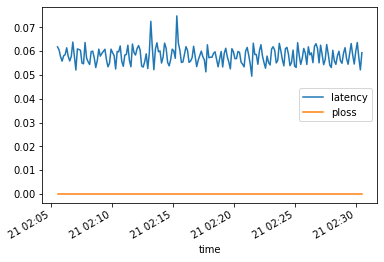

In [34]:
medidas_red.plot()
plt.show()

Supongamos que queremos obtener la latencia y tasa de pérdida de paquetes promedio por minuto. Para ello podemos usar de nuevo el método <code>groupby</code>. Pero antes, tendremos que establecer a qué minuto corresponde cada marca temporal y guardarlo en una columna. Pandas prevee este tipo de transformaciones, por lo que los índices temporales tienen un método <code>floor</code> que permite redondear cada entrada al minuto, hora o día:

In [35]:
medidas_red.index.floor('min')

DatetimeIndex(['2019-05-21 02:05:00', '2019-05-21 02:05:00',
               '2019-05-21 02:05:00', '2019-05-21 02:05:00',
               '2019-05-21 02:06:00', '2019-05-21 02:06:00',
               '2019-05-21 02:06:00', '2019-05-21 02:06:00',
               '2019-05-21 02:06:00', '2019-05-21 02:06:00',
               ...
               '2019-05-21 02:29:00', '2019-05-21 02:29:00',
               '2019-05-21 02:29:00', '2019-05-21 02:29:00',
               '2019-05-21 02:29:00', '2019-05-21 02:30:00',
               '2019-05-21 02:30:00', '2019-05-21 02:30:00',
               '2019-05-21 02:30:00', '2019-05-21 02:30:00'],
              dtype='datetime64[ns]', name='time', length=200, freq=None)

Cambiando el parámetro de <code>floor</code> podemos obtener diferentes redondeos. En la <a href="https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.floor.html">documentación</a> podemos encontrar mucha más información. Crearemos una nueva columna con esta información, que marque a cada fila con el minuto correspondiente:

In [36]:
medidas_red.loc[:,"minuto"] = medidas_red.index.floor('min')

Con esto, podemos proceder ya al <code>groupby</code>:

In [37]:
medidas_red_minuto = medidas_red.groupby("minuto").mean()
medidas_red_minuto

,latency,ploss
minuto,,
2019-05-21 02:05:00,0.058970,0.0
2019-05-21 02:06:00,0.058934,0.0
2019-05-21 02:07:00,0.058083,0.0
2019-05-21 02:08:00,0.057140,0.0
2019-05-21 02:09:00,0.057931,0.0
2019-05-21 02:10:00,0.057659,0.0
2019-05-21 02:11:00,0.058738,0.0
2019-05-21 02:12:00,0.057272,0.0
2019-05-21 02:13:00,0.061170,0.0


Podemos representar ambos <code>DataSet</code> juntos para ver cómo ha cambiado la frecuencia:

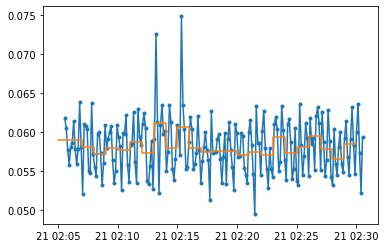

In [38]:
plt.plot(medidas_red.index, medidas_red.loc[:,"latency"], marker='.')
plt.step(medidas_red_minuto.index, medidas_red_minuto.loc[:,"latency"], where='post')
plt.show()

En el código anterior, hemos usado las funciones genéricas de Matplotlib, en lugar de la implementación de Pandas. La primera llamada dibuja una serie temporal con el eje X como el índice y los datos del eje Y como la variable que mide la latencia. En la segunda línea hemos dibujado la misma información acumulada por minuto, usando para ello la función <code>step</code> de forma que dibuje una recta para todo el intervalo cubierto. 

<div style="background-color:lightpink; padding:1em"><b>Ejercicio 7</b><br/>
    <p>Cambie la resolución de <code>medidas_red</code> a una frecuencia de cada 5 minutos. Para ello, tenga en cuenta que el parámetro que debe pasar a <code>floor</code> es <code>"5min"</code>. Represente la latencia para la resolución original, la resolución a un minuto y la resolución a cinco minutos en un mismo gráfico.</p>
</div>

## Feature engineering

A menudo, la transformación que necesitamos realizar sobre los datos consiste en calcular una nueva variable basada en los datos que tenemos o incluso en datos externos. Esto no es nada nuevo, ya lo hemos visto, por ejemplo, al crear una columna con los índices redondeados al minuto. Hay varios motivos por los que podríamos querer crear nuevas columnas:
- Usar información en un formato distinto al que tenemos. Por ejemplo, teniendo la información de consumo instantáneo de electricidad en kWh, podemos querer tener la información del consumo en euros.
- Reducir el número de columnas, agregando la información de varias en una única. Por ejemplo, podemos integrar la información de altura y peso de un grupo de personas calculando su índice de masa corporal. O bien podemos combinar la información de las 35 empresas más negociadas en la bolsa española en un único índice que llamamos <a href="https://www.bancosantander.es/glosario/ibex-35">IBEX 35</a>.
- Añadir una etiqueta de clase basada en el comportamiento de las otras columnas. Esto puede servir por ejemplo para hacer agrupaciones. Ya vimos un ejemplo sencillo con el índice temporal. 

El proceso de crear nuevas columnas con nueva información, recibe el nombre de <i>feature engineering</i>. Ya hemos visto algunos ejemplos muy sencillos. En esta sección veremos cómo podemos generar columnas nuevas basándonos en columnas existentes usando fórmulas conocidas.

### Combinación de columnas con una fórmula conocida

En primer lugar, veremos cómo podemos generar una nueva columna combinando varias. Para ello, recurriremos de nuevo a los datos de consumo de electricidad:

In [39]:
consumo = pd.read_csv("datos/consumo.csv", index_col=0, parse_dates=True)
consumo

,Consumo máximo (kW),Consumo acumulado (kWh),Precio (€/kWh),Tarifa
2021-09-08 14:00:00,3.2,1.5,0.179,LLANO
2021-09-08 15:00:00,2.5,0.9,0.172,LLANO
2021-09-08 16:00:00,2.1,0.1,0.181,LLANO
2021-09-08 17:00:00,2.6,0.1,0.202,LLANO
2021-09-08 18:00:00,5.6,1.2,0.302,PUNTA
2021-09-08 19:00:00,1.4,0.2,0.314,PUNTA


En este caso, el cálculo es muy simple; podemos simplemente multiplicar la columna <code>Consumo acumulado (kWh)</code> por la de <code>Precio (€/kWh)</code>:

In [40]:
consumo.loc[:,"Consumo acumulado (kWh)"] * consumo.loc[:,"Precio (€/kWh)"]

2021-09-08 14:00:00    0.2685
2021-09-08 15:00:00    0.1548
2021-09-08 16:00:00    0.0181
2021-09-08 17:00:00    0.0202
2021-09-08 18:00:00    0.3624
2021-09-08 19:00:00    0.0628
dtype: float64

Para crear la nueva columna, simplemente tenemos que asignar el valor:

In [41]:
consumo.loc[:,"Consumo (€)"] = consumo.loc[:,"Consumo acumulado (kWh)"] * consumo.loc[:,"Precio (€/kWh)"]
consumo

,Consumo máximo (kW),Consumo acumulado (kWh),Precio (€/kWh),Tarifa,Consumo (€)
2021-09-08 14:00:00,3.2,1.5,0.179,LLANO,0.2685
2021-09-08 15:00:00,2.5,0.9,0.172,LLANO,0.1548
2021-09-08 16:00:00,2.1,0.1,0.181,LLANO,0.0181
2021-09-08 17:00:00,2.6,0.1,0.202,LLANO,0.0202
2021-09-08 18:00:00,5.6,1.2,0.302,PUNTA,0.3624
2021-09-08 19:00:00,1.4,0.2,0.314,PUNTA,0.0628


<div style="background-color:lightpink; padding:1em"><b>Ejercicio 8</b><br/>
    <p>Con la tabla <code>pacientes</code> que se usó en el Ejercicio 2, calcule el Índice de Masa Corporal, dado por la siguiente fórmula:</p>
    $$
    IMC = \frac{peso (Kg)}{altura^2 (m)}
    $$
</div>

Cualquier operación que se pueda expresar como una combinación de las columnas se puede realizar de esta manera. Invariablemente, Pandas hará el cálculo fila por fila. Otra opción es usar la función <code>apply</code>, definiendo antes cómo queremos operar con los datos de la fila. Esta opción es más útil cuando queremos hacer un cálculo relativamente complejo, como por ejemplo con funciones definidas a trozos, o cálculos sujetos a condiciones. Supongamos, por ejemplo, que a un usuario no se le cobra en horario <code>LLANO</code>, independientemente del precio:

In [42]:
def calcular_precio(fila):
    if fila["Tarifa"] == "LLANO":
        return 0
    else:
        return fila["Consumo acumulado (kWh)"] * fila["Precio (€/kWh)"]

In [43]:
consumo.apply(calcular_precio, axis=1)

2021-09-08 14:00:00    0.0000
2021-09-08 15:00:00    0.0000
2021-09-08 16:00:00    0.0000
2021-09-08 17:00:00    0.0000
2021-09-08 18:00:00    0.3624
2021-09-08 19:00:00    0.0628
dtype: float64

Es importante remarcar que incluso operaciones complejas como ésta, se pueden expresar también como combinación de columnas, pero a veces el código resultante puede ser más confuso.

### Clasificación por reglas conocidas

La clasificación se puede hacer de una manera similar al cálculo de una columna nueva, sólo que los valores resultantes son categóricos. Ya vimos un ejemplo con el eje temporal. Veamos uno ahora en el que usamos una función para clasificar según los valores de la fila. Tomamos de nuevo los datos de calificación de un grupo de alumnos:

In [44]:
notas

,Alumno,Sexo,Equipo,Nota 1,Nota 2
0,Alberto,M,A,5.5,5.7
1,Beatriz,F,C,4.2,3.2
2,Cristina,F,B,2.2,4.4
3,Daniel,M,C,6.8,5.4
4,Estefanía,F,A,5.6,5.8
5,Francisco,M,A,7.1,7.5
6,Gabriela,F,B,3.3,5.3
7,Héctor,M,C,4.8,3.8
8,Irene,F,C,8.8,9.7
9,Juan,M,A,6.0,6.1


Supongamos que queremos calificar a cada alumno según la siguiente tabla:
<table>
    <tr><th>Nota</th><th>Calificación</th></tr>
    <tr><td> &lt;5 </td><td>SUSPENSO</td></tr>
    <tr><td> 5-7 </td><td>APROBADO</td></tr>
    <tr><td> 7-9 </td><td>NOTABLE</td></tr>
    <tr><td> 9-10 </td><td>SOBRESALIENTE</td></tr>
</table>
Y para ello, tomaremos la nota media de ambos exámenes. Definimos la función que nos devuelve la calificación:

In [45]:
def calificar (fila):
    nota_media = (fila["Nota 1"] + fila["Nota 2"]) / 2
    if nota_media < 5:
        return "SUSPENSO"
    elif 5 <= nota_media < 7:
        return "APROBADO"
    elif 7 <= nota_media < 9:
        return "NOTABLE"
    else:
        return "SOBRESALIENTE"

Pasando esta función a <code>apply</code>, podemos realizar la clasificación:

In [46]:
notas.apply(calificar, axis=1)

0          APROBADO
1          SUSPENSO
2          SUSPENSO
3          APROBADO
4          APROBADO
5           NOTABLE
6          SUSPENSO
7          SUSPENSO
8     SOBRESALIENTE
9          APROBADO
10         APROBADO
11          NOTABLE
12         APROBADO
13         APROBADO
14    SOBRESALIENTE
dtype: object

Para crear la nueva columna, de nuevo, tendremos que asignar el valor:

In [47]:
notas.loc[:,"Calificación"] = notas.apply(calificar, axis=1)
notas

,Alumno,Sexo,Equipo,Nota 1,Nota 2,Calificación
0,Alberto,M,A,5.5,5.7,APROBADO
1,Beatriz,F,C,4.2,3.2,SUSPENSO
2,Cristina,F,B,2.2,4.4,SUSPENSO
3,Daniel,M,C,6.8,5.4,APROBADO
4,Estefanía,F,A,5.6,5.8,APROBADO
5,Francisco,M,A,7.1,7.5,NOTABLE
6,Gabriela,F,B,3.3,5.3,SUSPENSO
7,Héctor,M,C,4.8,3.8,SUSPENSO
8,Irene,F,C,8.8,9.7,SOBRESALIENTE
9,Juan,M,A,6.0,6.1,APROBADO


<div style="background-color:lightpink; padding:1em"><b>Ejercicio 9</b><br/>
    <p>Dada la siguiente tabla de clasificación de IMC (simplificada):</p>
    <table>
        <tr><th>IMC</th><th>Clasificación</th></tr>
        <tr><td> &lt;18.5 </td><td>Delgadez</td></tr>
        <tr><td> 18.5-24.9 </td><td>Peso saludable</td></tr>
        <tr><td> &gt;24.9 </td><td>Sobrepeso</td></tr>
    </table>
    <p>defina una función que clasifique los IMC calculados en el Ejercicio 8, y añada una columna <code>Clasificación</code> a la tabla <code>pacientes</code>.
</div>

En esta libreta hemos visto las transformaciones básicas de los conjuntos de datos. Si bien estas operaciones pueden parecer demasiado simples, a lo largo de nuestra vida como analistas de datos, nos encontraremos muchísimo con ellas. Aunque en el imaginario colectivo las tareas de minería de datos suelan ser las más importantes, las tareas de preprocesado y transformación son las que llevan la mayor parte del peso de la extracción de valor. Tras estos procesos, a simple vista ya se pueden obtener grandes cantidades de información. De hecho, a menudo muchos estudios de datos se limitan a dicho preprocesado + transformación y a continuación la representación de los datos de manera vistosa, sin llegar a aplicar las técnicas de minería de datos. Esto es muy común cuando se quiere ofrecer información de datos al público (véase los estudios publicados sobre la pandemia del COVID o los resultados de las encuestas electorales que se realizan de forma recurrente). En la siguiente libreta veremos una técnica que está a medio camino entre la transformación y el análisis de datos: <i>Principal Component Analysis (PCA)</i>. Dicha técnica difiere en dos puntos fundamentales de las vistas aquí:
- Todas las técnicas que hemos visto aquí las hemos definido nosotros: las fórmulas para el cálculo de nuevas columnas, las reglas de agrupamiento y clasificación, etc. PCA es una técnica más compleja, por lo que nos limitaremos a usarla como ha sido programada.
- Las técnicas que hemos visto aquí usan el conocimiento del campo, mientas que PCA es indiferente a qué tipo de dato está procesando. Esto la hace aplicable sólo después de una preparación adecuada de los datos y un estudio de idoneidad. Aplicarla sin saber si conviene o no es un error muy común.

## Conclusiones

En esta libreta hemos visto un uso práctico de las funciones básicas de Pandas. Los <code>DataFrame</code> son estructuras ideales para la manipulación de datos. Concretamente hemos visto los siguientes puntos:
- Reindexado, que usaremos para cambiar la frecuencia de unos datos determinados, o para ponerlos en función de una variable distinta.
- Combinación de datos de distintas fuentes, con distintos formatos.
- Operación dividir/aplicar/recombinar, que se usa a menudo para cambiar el nivel de agregación de unos datos en función de una variable de clase.
- Feature engineering, para generar nuevas columnas en base a unas existentes, que se usa a menudo para reducir la dimensionalidad de los datos.

<a href="https://www.stitchdata.com/resources/data-transformation/">Aquí</a> y <a href="https://towardsdatascience.com/data-transformation-and-feature-engineering-e3c7dfbb4899">aquí</a> tenemos visiones complementarias del proceso de transformación de datos, y <a href="https://pbpython.com/pandas_transform.html">aquí</a> se habla de la función <code>transform</code> que ofrece una alternativa a la operación de dividir/aplicar/recombinar ofrecida en esta libreta.